In [1]:
import sys
import os
import cv2
import numpy as np
import random
from matplotlib import pyplot as plt
from IPython.display import clear_output
%matplotlib inline

### 5.2 Intensity based Object Tracking

In [24]:
# Setup for object tracking
if not os.path.isdir(os.path.join(os.getcwd(), 'frames')):
    os.mkdir("frames")
else:
    print('frames already exists')

if not os.path.isdir(os.path.join(os.getcwd(), 'composite')):
    os.mkdir("composite")
else:
    print('composite already exists')
    
framenumber = 0
framectr = 0
omovie = cv2.VideoCapture('ping_pang.mov')
frame_height = omovie.get(cv2.CAP_PROP_FRAME_HEIGHT)
frame_width  = omovie.get(cv2.CAP_PROP_FRAME_WIDTH)

# Extract the frames from original video
while(1):
    ret, frame = omovie.read()
    if not ret:
        break
    print('Extracting: %d' % framenumber)
    clear_output(wait=True)
    cv2.imwrite('frames/%d.tif' % framenumber, frame)
    framenumber += 1
omovie.release()
print('framenumber', framenumber, 'frame_height', frame_height, 'frame_width', frame_width)

framenumber 120 frame_height 1080.0 frame_width 1920.0


In [25]:
'''
    Find the object coordinate by averaging the foreground coordinates
    - Function Input: 
            -                frame: numpy array, the frame to be processed
    - Function Output:
            - [object_x, object_y]: the coordinate of the object in the frame
'''
def findObj(frame):
    ############# TO DO #############
    object_x = 0
    object_y = 0
    
    x_list = ()
    y_list = ()
   
    for x in range(frame.shape[0]):
        for y in range(frame.shape[1]):
            if frame[x][y][0] == 255:
                x_list+=(int(x),)
                y_list+=(int(y),)
#             for i in range(3):
#                 if frame[x][y][i] == 255:
#                     x_list+=(int(x),)
#                     y_list+=(int(y),)
#                     break
#                 else:
#                     N_thresh+=1
    
    #if ball is missing
#     or N_thresh == 0 
#     if len(x_list) ==0 or len(y_list) ==0 :
#         N_thresh = 100000
#         x_list += 1,
#         y_list += 1,
        
    N_thresh = len(x_list)    
    
    if N_thresh < 20:
        object_x = -1
        object_y = -1
    elif N_thresh > 20:
        object_x = int((np.sum(x_list)) / N_thresh)
        object_y = int((np.sum(y_list)) / N_thresh)
    
#     print(N_thresh)
    
    
    #############  END  #############
    return [object_x, object_y]


# Draw a circle on the image.
def drawbox(frame, centerx, centery, radius, color):
    for y in range(centery - radius, centery + radius):
        for x in range(centerx - radius, centerx + radius):
            cy = 0 if y < 0 else frame.shape[1] - 1 if y > frame.shape[1] - 1 else y
            cx = 0 if x < 0 else frame.shape[0] - 1 if x > frame.shape[0] - 1 else x
            for i in range(3):
                frame[cx][cy][i] = color[i]
    return frame

#### Implementation Tips:
* You can use `np.hstack((img1, img2))` to horizontally stack two images into one
* You can use `cv2.putText(combined_img, text='Sample Text', org=(2200, 1000), fontFace=cv2.FONT_HERSHEY_DUPLEX, fontScale=5, thickness = 5, color=(0, 255, 0)` to put text on a frame
* You can use `cv2.line(img, (x1, y1), (x2, y2), (0, 0, 255), 2)` to draw a red line between two points (x1, y1) and (x2, y2) 

In [26]:
framectr = framenumber - 1
process_frame = 0

foreground_tvalue = 250 # Foreground Threshold-Value (tvalue) for Segmentation
# Store the coordinates found by intensity thresholding
coordListX = list()
coordListY = list()

###test
# process_frame = 41
# framectr = 42
#######

while process_frame <= framectr:
    # Read RGB frame
    rgb_frame = cv2.imread('frames/%d.tif' % process_frame) # shape should be [1080, 1920, 3] -> [B, G, R]
    print('Processing frame: %d, overall progress: %.2f %%' % (process_frame, process_frame/framectr*100))
    clear_output(wait=True)
    
    # Object Segmentation 
    # 1. convert rgb_frame to gray scale, 
    # 2. then perform forground segmentation (based on its grayscale values).
    gframe = rgb_frame.copy() # g_frame for Grayscaled frame 
    for y in range(gframe.shape[1]):
        for x in range(gframe.shape[0]):
            # 1. Convert to gray scale
            g = 0.212671 * gframe[x][y][2] + 0.715160 * gframe[x][y][1] + 0.072169 * gframe[x][y][0] #value [0, 255]
            
            # 2. Perform forground segmentation to generate a binary mask 
            #   (0  -black-background)
            #   (255-white-foreground)
            for i in range(3):
                # gframe: gframe[x][y] = [g, g, g]
                gframe[x][y][i] = 255 if g > foreground_tvalue else 0 
    
    # Theoretically, g_frame should only contain 1 color-channel, i.e., (H*W*1)
    # However, here, we now set g_frame with 3 color-channel on purpose, i.e., (H*W*3)
    #        - as np.hstack() below expects g_frame and rgb_frame to share the same size.
    # So, you could simply treat g_frame as a "fake-rgb" frame (with 3 channels), 
    #        - and all three channels contain exactly the same information (grayscale image).
    
    # Get the initial state (object coordinates) from binary segmentation
    coord = findObj(gframe) # coord is the centre of mass
            
    # Draw a red dot in the centre of the segmented object
    rgb_frame = drawbox(rgb_frame, int(coord[0]), int(coord[1]), 5, (0, 0, 255))
    gframe    = drawbox(gframe   , int(coord[0]), int(coord[1]), 5, (0, 0, 255))
#     combined_img = np.hstack((rgb_frame, gframe))
    
   
    ####################################### TODO ###############################################
    # 1. You need to perform the object segmentation results on 'gframe'                       #
    # 2. You need to display the object moving trajectory on 'rgb_frame'                       #
    # 3. You need to display a text to determine whether the object is found or not in a frame #
    # 4. Please see the lab sheet for reference                                                #
    
    if len(coordListX) == 0:
        coordListX.append(0)
        coordListY.append(0)
 
    check = False
    
    if (coord[0] == -1 and coord[1] == -1):
        check = True
        present = False
        
    if (coord[0] != -1 and coord[1] != -1):
        
        present = True
        coordListX.append(coord[1])
        coordListY.append(coord[0])
#         x1 = coordListX[len(coordListX)-2]
#         x2 = coordListX[len(coordListX)-1]
#         y1 = coordListY[len(coordListY)-2]
#         y2 = coordListY[len(coordListY)-1]
        
    c = 0
    while c < len(coordListX)-1:
        x1 = coordListX[c]
        x2 = coordListX[c+1]
        y1 = coordListY[c]
        y2 = coordListY[c+1]
#         cv2.line(gframe, (x1, y1), (x2, y2), (0, 0, 255), 2)
        cv2.line(rgb_frame, (x1, y1), (x2, y2), (0, 0, 255), 2)
        c+=1

    if check and len(coordListX) != 0:
        coordListX.append(coordListX[len(coordListX)-1])
        coordListY.append(coordListY[len(coordListY)-1])
        
    combined_img = np.hstack((rgb_frame, gframe))
    if present:
        cv2.putText(combined_img, text='Object found', org=(2200, 1000), fontFace=cv2.FONT_HERSHEY_DUPLEX, fontScale=5, thickness = 5, color=(0, 255, 0))
    if not present:
        cv2.putText(combined_img, text='Object is missing', org=(2200, 1000), fontFace=cv2.FONT_HERSHEY_DUPLEX, fontScale=5, thickness = 5, color=(0, 255, 0))
    

    ####################################### END ################################################
    
    cv2.imwrite('composite/composite%d.tif' % process_frame, combined_img)
    if cv2.waitKey(30) & 0xff == ord('q'):
        break
    process_frame += 1

Processing frame: 119, overall progress: 100.00 %


In [27]:
count = 0
out = cv2.VideoWriter('./happy_ping_pang.mov', cv2.VideoWriter_fourcc('M', 'J', 'P', 'G'), 10, (int(frame_width*2), int(frame_height)))
while(1):
    img = cv2.imread('composite/composite%d.tif' % count)
    if img is None:
        print('No more frames to be loaded')
        break
    clear_output(wait=True)
    out.write(img)
    count += 1
    print('Saving video: %d%%' % int(100*count/framenumber))
    
out.release()
cv2.destroyAllWindows()

Saving video: 100%
No more frames to be loaded


### Intensity based Object Tracking - Week5 Lab Checkpoint Submission
You can now use the generate_results() function below to generate your outputs for submission. 

In [28]:
'''
    generate_results function is a helper function for you to generate
    the output images of lab exercise submission
    - Function Input: 
            -            wk:           int, indicates a specific week's lab exercise
            -          name:           str, the name of the student
            -           SID:           int, the SID of the student
            -  output_video:           str, the path to output_video

    - Function Usage:
            - Supply all the arguments with the correct types and a result image
              will be generated.
    - Tips:
            - You can right click the result image plot to save the image or 
              you can take a screenshoot for the submission.
'''
def generate_results(wk, name, SID, output_video):
    cap = cv2.VideoCapture(output_video)
    random_frames = []
    if not cap.isOpened():
        print('%s not opened' % output_video.split('/')[-1])
        sys.exit(1)

    frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    x = cap.get(cv2.CAP_PROP_FRAME_HEIGHT)
    y = cap.get(cv2.CAP_PROP_FRAME_WIDTH)
    while x > 10:
        x /= (x / 10)
        y /= (y / 10)
    
    random_frames.append(random.randint(53, 63))
    random_frames.append(random.randint(66, 76))
    random_frames.append(random.randint(80, 94))
        
    fig, axs = plt.subplots(3, 1, figsize=(x,y))
        
    count = 0
    output_count = 0
    while(1):
        ret, frame = cap.read()
        if not ret:
            break
        if count in random_frames:
            frame_m = frame.copy()
            frame_R = frame[:,:,2]
            frame_B = frame[:,:,0]
            frame_m[:,:,2] = frame_B
            frame_m[:,:,0] = frame_R
            frame = np.uint8(frame_m)

            axs[output_count].imshow(frame_m)
            axs[output_count].text(0.5, -0.1, 'Composite frame: ' + str(count), size=12, ha="center", transform=axs[output_count].transAxes)
            axs[output_count].axis('off')
            output_count+=1
            
            if output_count >= 3:
                break
        count+=1

    cap.release()
    cv2.destroyAllWindows()
    fig.suptitle("Week %i Lab Exercise\n %s SID:%i"%(wk, name, SID),x=0.5,y=1.05)
    plt.tight_layout()
    plt.show()

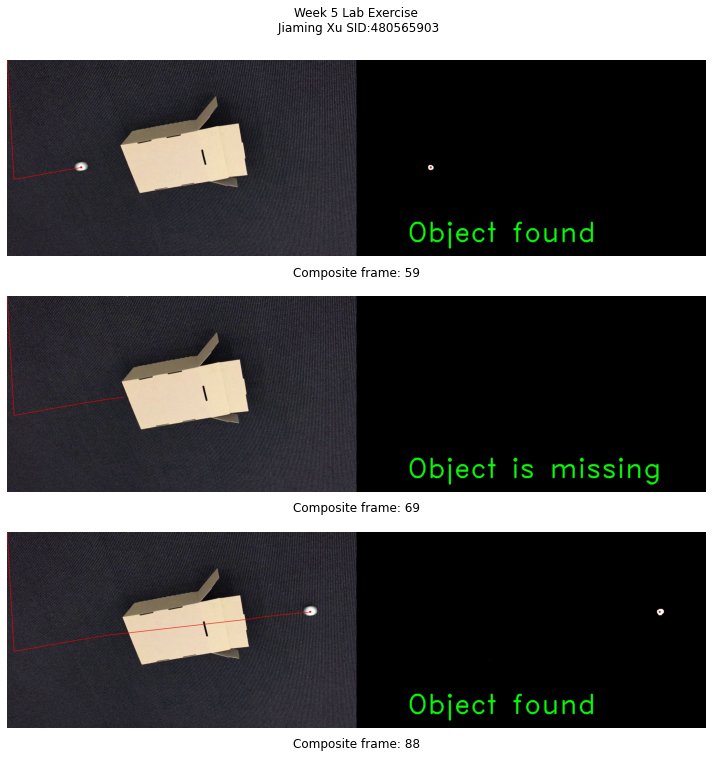

In [30]:
# Change the 'path_to_output' to the path where your composited video is located
path_to_output = './happy_ping_pang.mov'
generate_results(5, 'Jiaming Xu', 480565903, path_to_output)